# COMP9517 Group Project

### Model 2 : DeepLabV3+

Please run this file after dataVisualisation.ipynb. Afterwards, you can run any model in any order.

In [23]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2 as cv
import numpy as np
import segmentation_models_pytorch as smp

#### DataLoader

First we will load back in all the datasplits we created back in dataVisualisation.ipynb. To do this, we will need to again import back in the SeaTurtleDataset custom class we created for this dataset. This simply involves copying what we had back to here.

In [24]:
###################################################################
# Nothing new here, just same as dataVisualisation.ipynb.
###################################################################

resize_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

annotation_file = "./turtles-data/data/updated_annotations.json"
coco = COCO(annotation_file)


class SeaTurtleDataset(Dataset):
    def __init__(self, image_ids, transform=None):
        self.coco = COCO("./turtles-data/data/updated_annotations.json")
        self.image_ids = image_ids
        self.cat_ids = self.coco.getCatIds()
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_data = self.coco.loadImgs([image_id])[0]

        image_path = os.path.join("./turtles-data/data", image_data["file_name"])
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        mask = self._getmask(self.image_ids[index], image)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

    def _getmask(self, image_id, image):
        """
        Background (0):   000000000000000
        Turtle Body (1):  111111100000000
        Flippers (2):     112222200000000
        Head (3):         112222233300000

        Final Mask:       112222233300000
        """
        categories = {"turtle": 1, "flipper": 2, "head": 3}
        # Initialize the final mask with zeros
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Process each category
        for category_name, category_id in categories.items():
            ann_ids = self.coco.getAnnIds(
                imgIds=image_id, catIds=category_id, iscrowd=None
            )
            annotations = self.coco.loadAnns(ann_ids)

            # Create a temporary mask for the current category
            temp_mask = np.zeros_like(mask)

            for ann in annotations:
                temp_mask += self.coco.annToMask(ann)
            # Assign category-specific value to the final mask
            if category_name == "turtle":
                mask[temp_mask > 0] = 1
            elif category_name == "flipper":
                mask[temp_mask > 0] = 2
            elif category_name == "head":
                mask[temp_mask > 0] = 3

        return mask

loading annotations into memory...
Done (t=2.69s)
creating index...
index created!


Next, we will load our train val split from /models into our code here.

In [41]:
import pandas as pd

metadata_path = "turtles-data/data/metadata_splits.csv"
metadata = pd.read_csv(metadata_path)

# Get the list of valid IDs from COCO
coco_ids = set(coco.getImgIds())

# Filter each set of IDs to only include those that are also in the COCO dataset
train_ids = [id_ for id_ in metadata[metadata["split_open"] == "train"]["id"] if id_ in coco_ids]
test_ids = [id_ for id_ in metadata[metadata["split_open"] == "test"]["id"] if id_ in coco_ids]
val_ids = [id_ for id_ in metadata[metadata["split_open"] == "valid"]["id"] if id_ in coco_ids]

train_ids_subset = train_ids[: int(0.6 * len(train_ids))]
test_ids_subset = test_ids[: int(0.2 * len(test_ids))]
val_ids_subset = val_ids[: int(0.7 * len(val_ids))]

print("train_ids length:", len(train_ids_subset))
print("test_ids length:", len(test_ids_subset))
print("val_ids length:", len(val_ids_subset))

train_dataset = SeaTurtleDataset(train_ids_subset, transform=resize_transform)
val_dataset = SeaTurtleDataset(val_ids_subset, transform=resize_transform)
test_dataset = SeaTurtleDataset(test_ids_subset, transform=resize_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)


train_ids length: 3175
test_ids length: 459
val_ids length: 781
loading annotations into memory...
Done (t=3.18s)
creating index...
index created!
loading annotations into memory...
Done (t=2.81s)
creating index...
index created!
loading annotations into memory...
Done (t=3.81s)
creating index...
index created!


In [26]:
def compute_IoU(outputs, masks, target_class):
    # Get the predicted class for each pixel
    outputs = outputs.argmax(dim=1)
    intersection = ((outputs == target_class) & (masks == target_class)).sum().item()
    union = ((outputs == target_class) | (masks == target_class)).sum().item()
    if union == 0:
        return float('nan')
    else:
        return intersection / union
    
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",  
    classes=4,                    
    activation='softmax2d'
)

num_classes = 4  # background + 3 classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [27]:
def visualize_prediction(image, mask, prediction, figsize=(15,5)):
   # Convert tensors to numpy arrays
   if isinstance(image, torch.Tensor):
       image = image.cpu().numpy()
       if image.shape[0] == 3:
           image = image.transpose(1, 2, 0)
       
   if isinstance(mask, torch.Tensor):
       mask = mask.cpu().numpy()
       
   if isinstance(prediction, torch.Tensor):
       prediction = prediction.cpu().numpy()
   
   # Denormalize image
   mean = np.array([0.485, 0.456, 0.406])
   std = np.array([0.229, 0.224, 0.225])
   image = np.clip((image * std + mean), 0, 1)
   
   # Create color maps for mask and prediction
   colors = [(0,0,0), (1,0,0), (0,1,0), (0,0,1)]
   colored_mask = np.zeros((*mask.shape, 3))
   colored_pred = np.zeros((*prediction.shape, 3))
   
   for i, color in enumerate(colors):
       colored_mask[mask == i] = color
       colored_pred[prediction == i] = color
   
   # Plot
   plt.figure(figsize=figsize)
   
   plt.subplot(1, 3, 1)
   plt.imshow(image)
   plt.title('Original Image')
   plt.axis('off')
   
   plt.subplot(1, 3, 2)
   plt.imshow(colored_mask)
   plt.title('Ground Truth Mask')
   plt.axis('off')
   
   plt.subplot(1, 3, 3)
   plt.imshow(colored_pred)
   plt.title('Model Prediction')
   plt.axis('off')
   
   plt.tight_layout()
   plt.show()

#### Training

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Define class labels for each category
turtle_class = 1
flipper_class = 2
head_class = 3

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_loss = 0
    
    # Training loop
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Print every 100 batches
        if batch_idx % 100 == 0:  
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    # Average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")
    
    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss:.4f}")

    # Compute mIoU on the test set
    turtle_IoUs, flipper_IoUs, head_IoUs = [], [], []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device).long()
            outputs = model(images)
            
            # Compute IoU for each category
            for i in range(len(images)):  # Process each image in the batch
                turtle_IoUs.append(compute_IoU(outputs[i:i+1], masks[i:i+1], turtle_class))
                flipper_IoUs.append(compute_IoU(outputs[i:i+1], masks[i:i+1], flipper_class))
                head_IoUs.append(compute_IoU(outputs[i:i+1], masks[i:i+1], head_class))

    turtle_mIoU = np.nanmean(turtle_IoUs)
    flipper_mIoU = np.nanmean(flipper_IoUs)
    head_mIoU = np.nanmean(head_IoUs)
    
    print(f"Turtle (Carapace) mIoU on Test Set after Epoch {epoch+1}: {turtle_mIoU:.4f}")
    print(f"Flippers mIoU on Test Set after Epoch {epoch+1}: {flipper_mIoU:.4f}")
    print(f"Head mIoU on Test Set after Epoch {epoch+1}: {head_mIoU:.4f}")
    
    model.train()  # Set back to training mode

# Save model
PATH = "deeplab.pth"
torch.save(model.state_dict(), PATH)


Epoch 1/10
Batch 0/794 - Loss: 1.4783
Batch 100/794 - Loss: 0.9027
Batch 200/794 - Loss: 0.8147
Batch 300/794 - Loss: 0.7930
Batch 400/794 - Loss: 0.7718
Batch 500/794 - Loss: 0.7758
Batch 600/794 - Loss: 0.7715
Batch 700/794 - Loss: 0.7676
Epoch 1 Average Loss: 0.8247
Validation Loss after Epoch 1: 0.7674
Turtle (Carapace) mIoU on Test Set after Epoch 1: 0.8394
Flippers mIoU on Test Set after Epoch 1: 0.6624
Head mIoU on Test Set after Epoch 1: 0.6903

Epoch 2/10
Batch 0/794 - Loss: 0.7621
Batch 100/794 - Loss: 0.7651
Batch 200/794 - Loss: 0.8659
Batch 300/794 - Loss: 0.7569
Batch 400/794 - Loss: 0.7590
Batch 500/794 - Loss: 0.7589
Batch 600/794 - Loss: 0.7553
Batch 700/794 - Loss: 0.7564
Epoch 2 Average Loss: 0.7606
Validation Loss after Epoch 2: 0.7571
Turtle (Carapace) mIoU on Test Set after Epoch 2: 0.8873
Flippers mIoU on Test Set after Epoch 2: 0.7480
Head mIoU on Test Set after Epoch 2: 0.7331

Epoch 3/10
Batch 0/794 - Loss: 0.7582
Batch 100/794 - Loss: 0.7564
Batch 200/794 - 

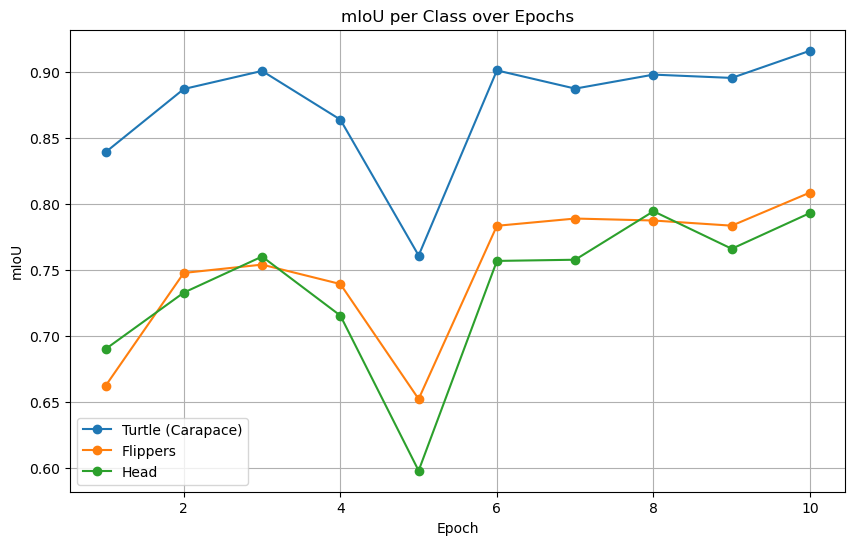

In [ ]:
epochs = list(range(1, 11))

# mIoU values extracted from your training log
turtle_mIoU = [0.8394, 0.8873, 0.9010, 0.8641, 0.7612, 0.9014, 0.8876, 0.8982, 0.8957, 0.9163]
flippers_mIoU = [0.6624, 0.7480, 0.7543, 0.7396, 0.6525, 0.7837, 0.7892, 0.7877, 0.7838, 0.8089]
head_mIoU = [0.6903, 0.7331, 0.7604, 0.7157, 0.5982, 0.7571, 0.7580, 0.7947, 0.7663, 0.7934]

# Plotting the mIoU for each class
plt.figure(figsize=(10, 6))
plt.plot(epochs, turtle_mIoU, marker='o', label='Turtle (Carapace)')
plt.plot(epochs, flippers_mIoU, marker='o', label='Flippers')
plt.plot(epochs, head_mIoU, marker='o', label='Head')

plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('mIoU per Class over Epochs')

plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def compute_per_class_metrics(outputs, masks, num_classes):
    # Flatten the tensors to 1D arrays
    outputs = outputs.view(-1).cpu().numpy()
    masks = masks.view(-1).cpu().numpy()
    
    # Initialize arrays to store metrics
    precision = []
    recall = []
    f1 = []
    support = []
    
    for cls in range(num_classes):
        # Binary mask for the current class
        outputs_cls = (outputs == cls).astype(int)
        masks_cls = (masks == cls).astype(int)
        
        # Compute metrics
        precision_cls = precision_score(masks_cls, outputs_cls, zero_division=0)
        recall_cls = recall_score(masks_cls, outputs_cls, zero_division=0)
        f1_cls = f1_score(masks_cls, outputs_cls, zero_division=0)
        support_cls = masks_cls.sum()
        
        precision.append(precision_cls)
        recall.append(recall_cls)
        f1.append(f1_cls)
        support.append(support_cls)
        
    return precision, recall, f1, support


    # [Your training code]
    
    # After validation and mIoU computation
    # Compute per-class precision, recall, F1-score
model.eval()
num_classes = 4
precision_per_class = [[] for _ in range(num_classes)]
recall_per_class = [[] for _ in range(num_classes)]
f1_per_class = [[] for _ in range(num_classes)]
support_per_class = [[] for _ in range(num_classes)]

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device).long()
        outputs = model(images)
        predictions = outputs.argmax(dim=1)
        
        batch_precision, batch_recall, batch_f1, batch_support = compute_per_class_metrics(predictions, masks, num_classes)
        
        for cls in range(num_classes):
            precision_per_class[cls].append(batch_precision[cls])
            recall_per_class[cls].append(batch_recall[cls])
            f1_per_class[cls].append(batch_f1[cls])
            support_per_class[cls].append(batch_support[cls])
    
    avg_precision_per_class = [np.mean(precision_per_class[cls]) for cls in range(num_classes)]
    avg_recall_per_class = [np.mean(recall_per_class[cls]) for cls in range(num_classes)]
    avg_f1_per_class = [np.mean(f1_per_class[cls]) for cls in range(num_classes)]
    total_support_per_class = [np.sum(support_per_class[cls]) for cls in range(num_classes)]
    class_names = ['Background', 'Turtle (Carapace)', 'Flippers', 'Head']

    print(f"\nMetrics after Epoch {epoch+1}:")
    for cls in range(num_classes):
        print(f"Class: {class_names[cls]}")
        print(f"  Precision: {avg_precision_per_class[cls]:.4f}")
        print(f"  Recall:    {avg_recall_per_class[cls]:.4f}")
        print(f"  F1-score:  {avg_f1_per_class[cls]:.4f}")
        print(f"  Support:   {total_support_per_class[cls]}")


KeyboardInterrupt: 

Randomly visualise 5 images and its predictions with the saved model

C:\Users\Raymond Cen\AppData\Local\Temp\ipykernel_30680\1667165467.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deeplab.pth'))


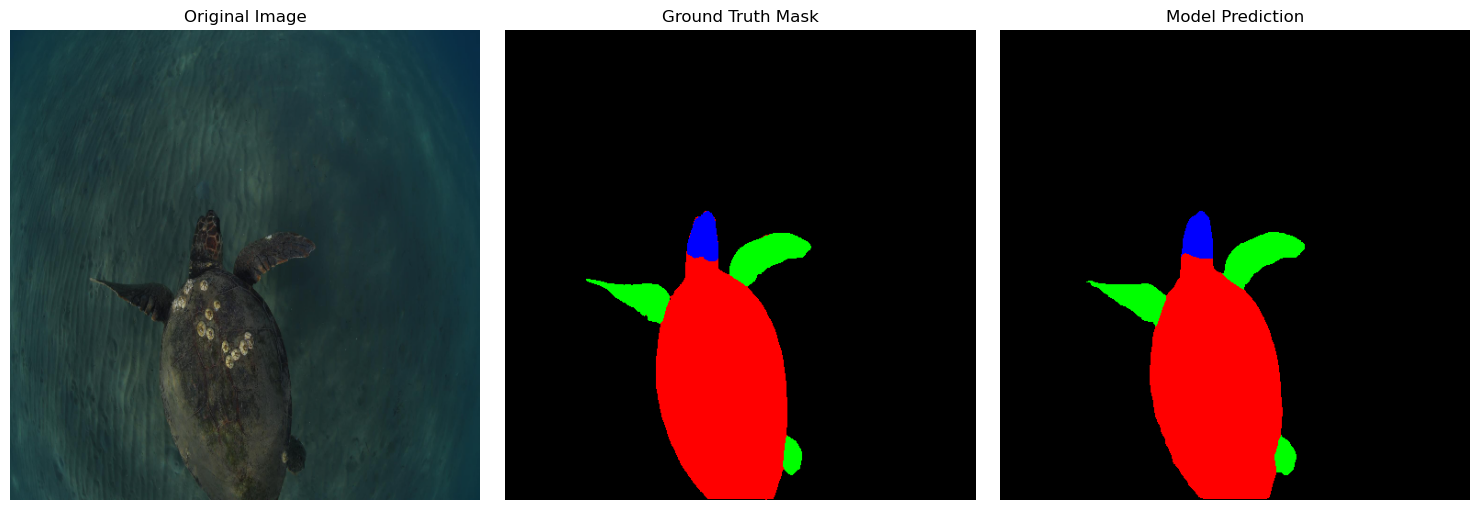

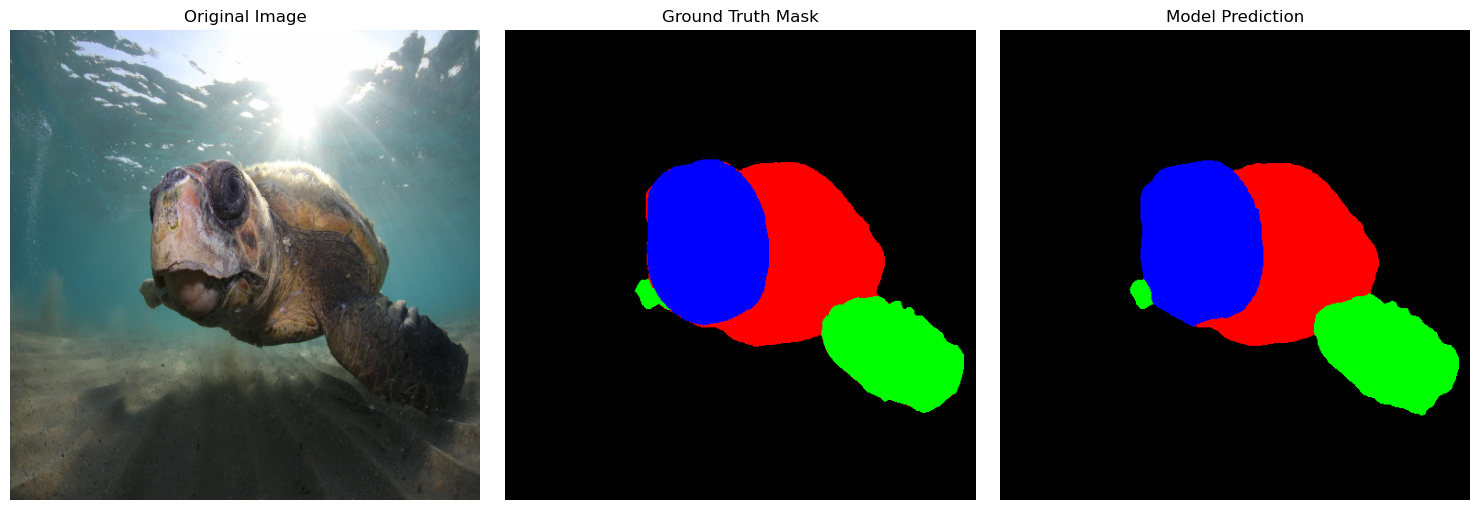

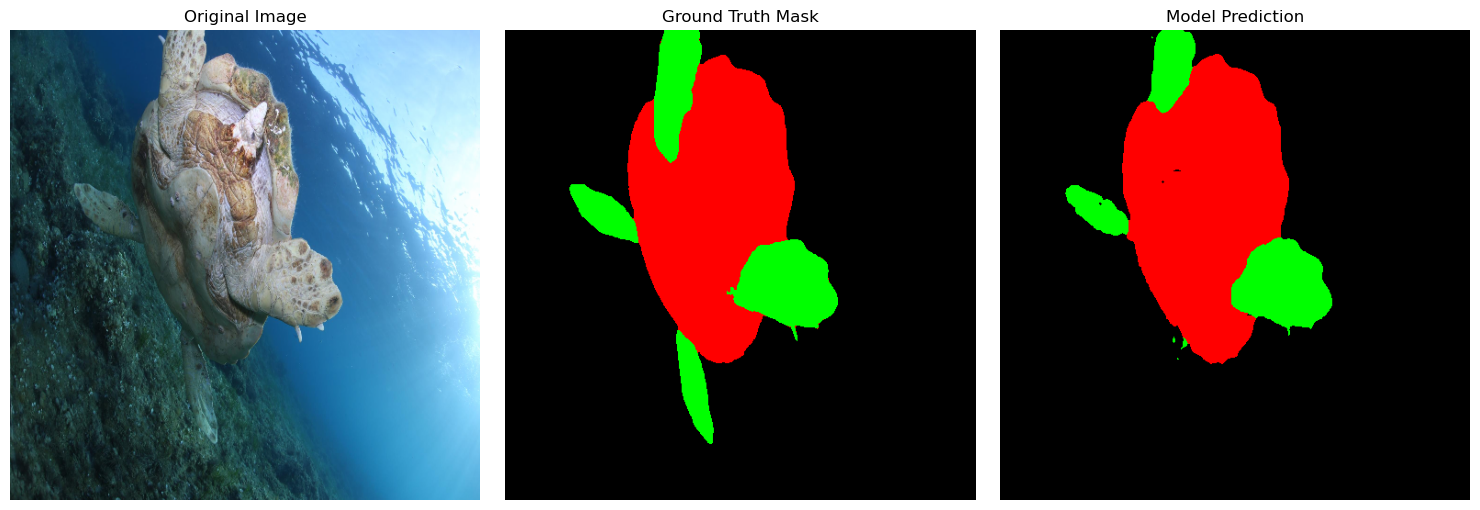

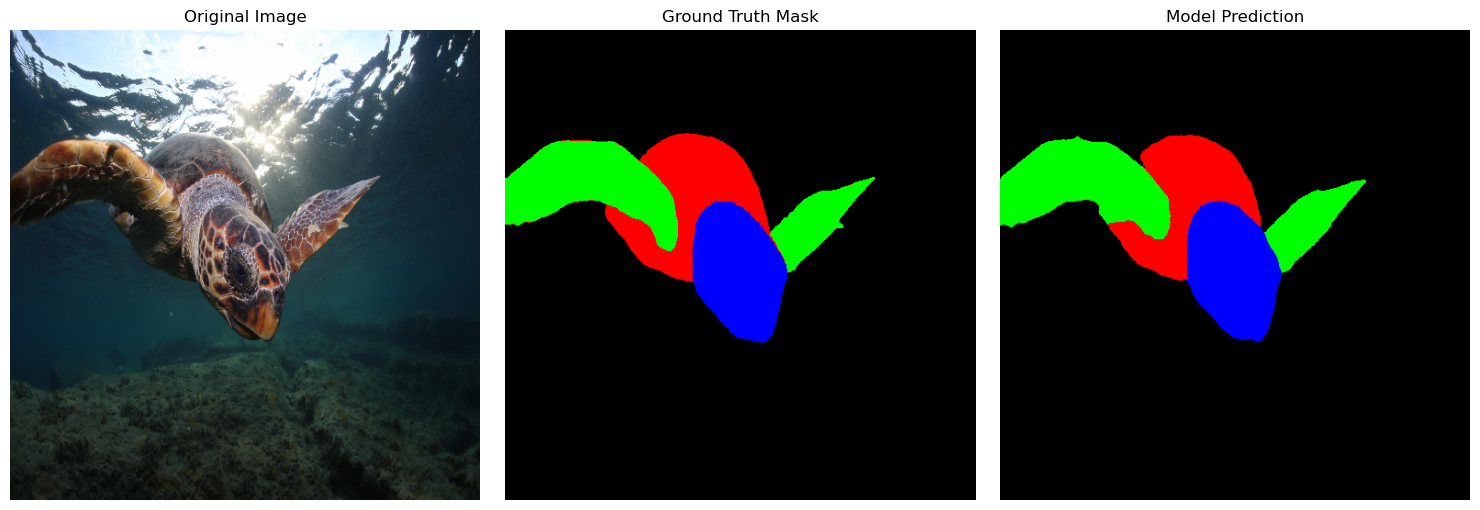

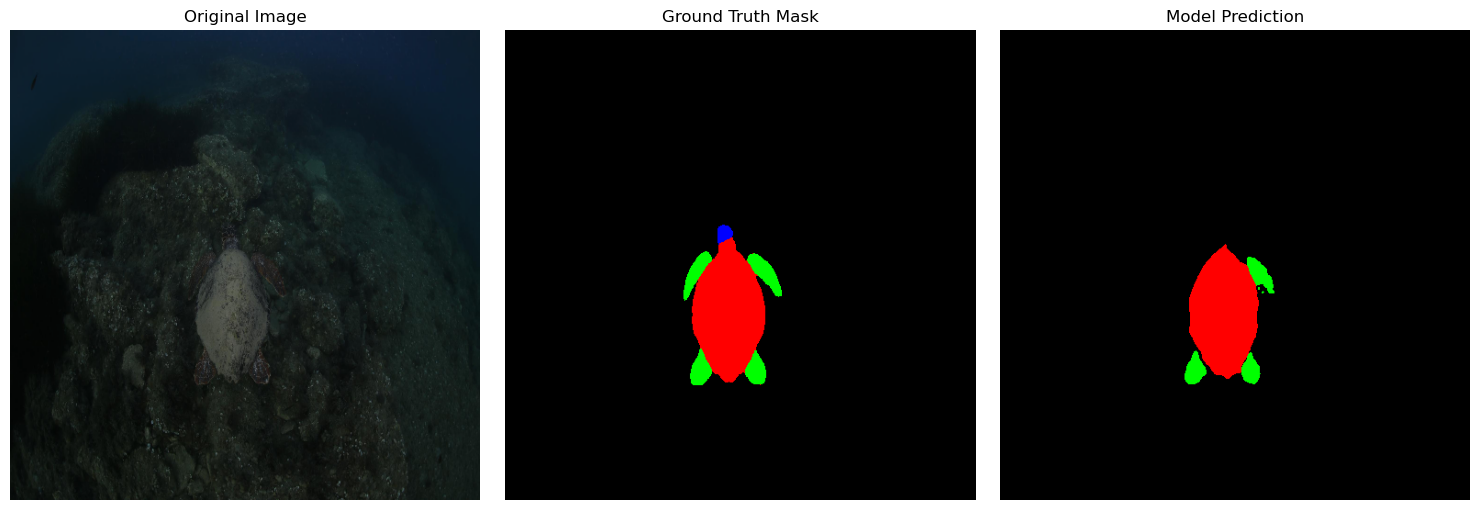

In [ ]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",  
    classes=4,                    
    activation='softmax2d'
)
model = model.to(device)
model.load_state_dict(torch.load('deeplab.pth'))
model.eval()

num_images_to_visualize = 5

total_val_samples = len(val_loader.dataset)

random_indices = random.sample(range(total_val_samples), num_images_to_visualize)

for idx in random_indices:
    # Get the image and mask at the random index
    image, mask = val_loader.dataset[idx]
    image = image.to(device).unsqueeze(0)
    mask = mask.to(device)
    
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).squeeze(0)
    
    visualize_prediction(image.squeeze(0), mask, prediction)
